In [2]:
import glob
from skimage.transform import resize
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import skimage.transform
import tensorflow as tf
import os
import cv2

In [3]:
tf.__version__

'1.14.0'

In [4]:
def read_dataset(Directory):

  labels = []
  images = []
  
  directories = [direc for direc in os.listdir(Directory) 
                   if os.path.isdir(os.path.join(Directory, direc))]

  for direc in directories:
        label = os.path.join(Directory, direc)
        img_names = [os.path.join(label, img) 
                      for img in os.listdir(label) if img.endswith(".ppm")]
       
        for img in img_names:
          imag = cv2.imread(img)
          imag = skimage.transform.resize(imag, (32, 32), mode='constant')
          images.append(imag)
          labels.append(int(direc))

  return images, labels

In [5]:
images, labels = read_dataset('C:/Users/DR.LAP/BelgiumTSC/BelgiumTSC/Training')
images_test, labels_test = read_dataset('C:/Users/DR.LAP/BelgiumTSC/BelgiumTSC/Testing')

In [6]:
print("Number Of Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Number Of Unique Labels: 62
Total Images: 4575


In [7]:
np_labels = np.array(labels)
np_images = np.array(images)
print("labels: ", np_labels.shape, "\nimages: ", np_images.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [8]:
np_test_images = np.array(images_test)
np_test_labels = np.array(labels_test)
print("labels: ", np_test_labels.shape, "\nimages: ", np_test_images.shape)

labels:  (2520,) 
images:  (2520, 32, 32, 3)


In [9]:
labelsn= np.array(labels)
z=[]
for i in range(62):
  z.append(np.count_nonzero(labelsn == i))

In [10]:
def display_images(images, label):
    fig= plt.figure(figsize=(8,10))
    fig.patch.set_facecolor('grey')
    fig.patch.set_alpha(.3)
    image = labels.index(label)
    plt.title(label)
    plt.subplot(5, 4, 1)
    plt.axis('off') 
    plt.imshow(images[image+1])
    color='yellow'
    plt.text(-1, 50, "Sign From Class: {0} \nContains: {1} Image".format(label,z[label]),fontsize=16, color=color)
    plt.show()

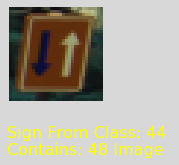

In [11]:
#choose a label from 0 to 61 to plot photo
display_images(images, 44)

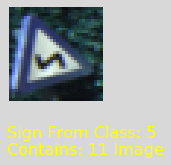

In [12]:
display_images(images, 5)

In [13]:
graph = tf.Graph()


with graph.as_default():
    
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    
    images_flat = tf.contrib.layers.flatten(images_ph)

    
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    
    predicted_labels = tf.argmax(logits, 1)

    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [14]:
session = tf.Session(graph=graph)
_ = session.run([init])

In [15]:
for i in range(201):
    _, loss_value = session.run([train, loss], feed_dict={images_ph: np_images, labels_ph: np_labels})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.181758
Loss:  2.7796435
Loss:  2.2712119
Loss:  2.0323641
Loss:  1.89413
Loss:  1.8002372
Loss:  1.730022
Loss:  1.6743038
Loss:  1.6280867
Loss:  1.5884334
Loss:  1.5541079
Loss:  1.5240386
Loss:  1.4973935
Loss:  1.4734775
Loss:  1.4519099
Loss:  1.4323617
Loss:  1.4145373
Loss:  1.3982084
Loss:  1.3831873
Loss:  1.3693188
Loss:  1.356471


In [16]:
predict_test = session.run([predicted_labels], feed_dict={images_ph: np_test_images})[0]

match_count = sum(
    [int(y == y_) 
     for y, y_ in zip(np_test_labels, predict_test)
    ]
)
accuracy = match_count / len(np_test_labels) *100
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 68.056


In [17]:
def plot_image(images_num):
  fig = plt.figure(figsize=(11, 10))
  real_label = np_test_labels[images_num]
  prediction = predict_test[images_num]
  predictedClassImgLabel = np.where(np_test_labels == prediction)
  ImgFromPredictedClass=predictedClassImgLabel[0][0]
  i=1
 
  for x in range(2):
    plt.subplot(5,2,i)
    plt.axis('off')
    plt.imshow(np_test_images[images_num])
    images_num = ImgFromPredictedClass
    i+=1
  color='purple' if real_label == prediction else 'yellow'
  plt.text(-75, 22, "True Label: {0} (Left Image)\nPredicted: {1} (Right Image)".format(real_label, prediction), 
             fontsize=14, color=color,bbox=dict(facecolor='black', alpha=0.4))
  plt.show()

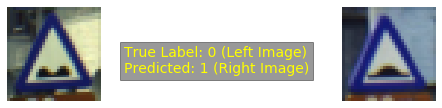

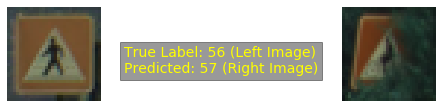

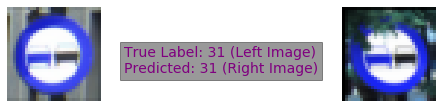

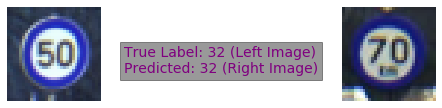

In [22]:
plot_image(2)
plot_image(2320)
plot_image(1000)
plot_image(1305)

In [19]:
classes = []
for i in range(62):
    classes.append(i)

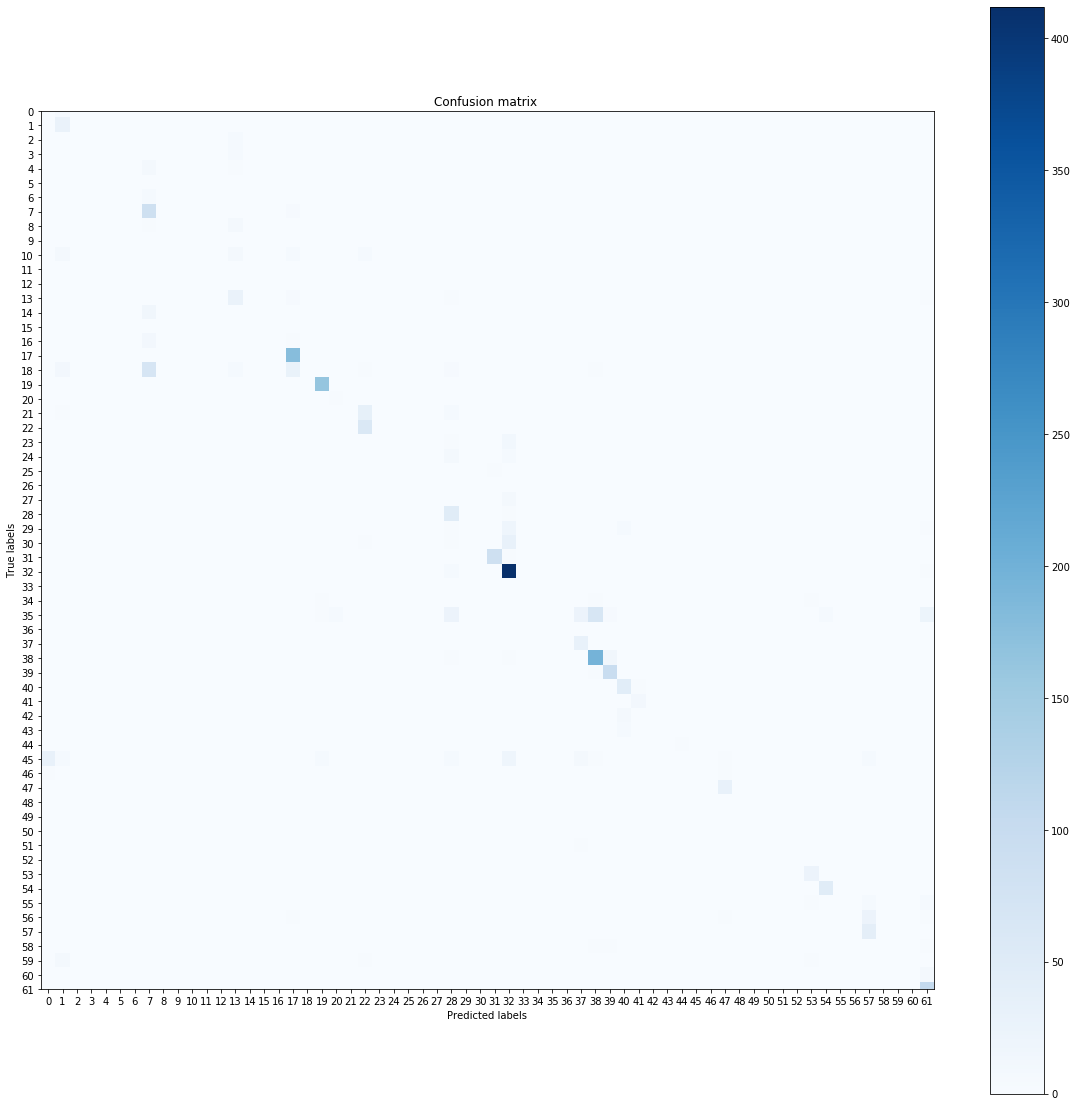

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
cm = metrics.confusion_matrix(np_test_labels, predict_test,classes)
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(classes)
plt.yticks(classes)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [34]:
session.close()